# 🔗 Pipeline (scikit-learn)

## 📌 개요
- 여러 단계(전처리기, 변환기, 추정기)를 **연속적으로 연결**하여 실행하는 도구
- 전처리와 모델을 하나의 객체처럼 다룰 수 있음
- 교차검증, 하이퍼파라미터 탐색(GridSearchCV, RandomizedSearchCV)에서 특히 유용
- 데이터 누수(leakage) 방지: `fit_transform`이 학습 데이터에만 적용되도록 자동 관리

---

## 📌 주요 매개변수 (Parameters)

- **steps** : list of (str, transformer/estimator)  
  - 파이프라인의 단계들을 이름과 객체 쌍으로 묶은 리스트  
  - 예: `[("scaler", StandardScaler()), ("pca", PCA()), ("svc", SVC())]`

- **memory** : str or object, default=None  
  - 변환기의 중간 결과를 캐싱할 경로 (예: `"./cache"`)  
  - 동일한 계산을 반복할 때 속도 향상 가능

- **verbose** : bool, default=False  
  - `True`면 각 단계 실행 여부를 로그로 출력  

---

## 📌 주요 속성 (Attributes)

- **named_steps** : dict  
  - 파이프라인의 각 단계를 딕셔너리처럼 이름으로 접근 가능  
  - 예: `pipe.named_steps["svc"]`

- **steps** : list  
  - 정의된 단계 리스트  

---

## 📌 주요 메서드 (Methods)

- **fit(X, y=None, \*\*fit_params)**  
  - 순서대로 각 단계의 `fit` 실행  
  - 마지막 단계는 반드시 `estimator` (예측 가능한 모델) 이어야 함

- **fit_transform(X, y=None, \*\*fit_params)**  
  - 각 단계의 `fit_transform` 실행 후 변환된 데이터 반환  
  - 마지막 단계는 변환기여야 함

- **predict(X, \*\*predict_params)**  
  - 마지막 단계(estimator)에서 `predict` 실행

- **predict_proba(X)**  
  - 분류 모델일 경우, 마지막 단계의 `predict_proba` 실행

- **score(X, y=None, sample_weight=None)**  
  - 마지막 단계(estimator)의 `score` 메서드 실행

- **transform(X)**  
  - 마지막 단계까지 `transform` 실행  
  - 마지막 단계도 변환기여야 함

- **inverse_transform(Xt)**  
  - 변환된 데이터 Xt를 원래 형태로 되돌림 (해당 단계 지원 시)

- **get_params(deep=True)**  
  - 파라미터 조회 (GridSearchCV에서 `<단계명>__<파라미터명>` 형식으로 접근 가능)

- **set_params(\*\*params)**  
  - 파라미터 설정

---

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 1. 데이터 로드
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. 파이프라인 구성 (스케일링 + SVM)
pipe = Pipeline([
    ("scaler", StandardScaler()),  # 전처리 단계
    ("svc", SVC(probability=True, random_state=42))  # 모델 단계
])

# 3. 그리드 서치 파라미터
param_grid = {
    "svc__C": [0.1, 1, 10],        # SVC의 C 값
    "svc__kernel": ["linear", "rbf"],  # 커널 종류
    "svc__gamma": ["scale", "auto"]    # 감마 값
}

# 4. GridSearchCV 설정
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# 5. 학습
grid.fit(X_train, y_train)

# 6. 결과 확인
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
print("Test Score:", grid.score(X_test, y_test))

# 7. 분류 리포트
y_pred = grid.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV Score: 0.975
Test Score: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



# 🔍 GridSearchCV

## 📌 개요
- **GridSearchCV**는 "모든 하이퍼파라미터 조합(grid)을 탐색"하여 최적의 조합을 찾는 방법.
- 각 파라미터 조합별로 **교차검증(Cross-Validation, CV)**을 수행해 평균 성능을 비교.
- 최적의 모델(`best_estimator_`)과 성능(`best_score_`)을 자동으로 제공.

---

## 📌 주요 매개변수 (Parameters)

- **estimator** :  
  - 학습할 모델 객체 (예: `SVC()`, `RandomForestClassifier()` 등)  

- **param_grid** : dict or list of dict  
  - 탐색할 하이퍼파라미터의 값 집합  
  - 예:  
    ```python
    {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ```  

- **scoring** : str, callable, or None (default=None)  
  - 평가 지표 설정  
  - 예: `"accuracy"`, `"f1"`, `"roc_auc"`, 커스텀 스코어 함수도 가능  

- **cv** : int, cross-validation generator or iterable (default=None)  
  - 교차 검증 분할 수  
  - `cv=5` → 5-폴드 교차검증  

- **n_jobs** : int (default=None)  
  - 병렬 처리 개수  
  - `-1` → 가능한 모든 CPU 코어 사용  

- **refit** : bool or str (default=True)  
  - 최적 파라미터로 전체 데이터를 다시 학습할지 여부  
  - `True` → `best_estimator_` 사용 가능  
  - 특정 스코어 지표를 refit 기준으로 삼을 수도 있음 (예: `refit="f1"`)  

- **verbose** : int (default=0)  
  - 출력 로그 수준 (0=없음, 1=간단, 2=상세)  

- **pre_dispatch** : int or str (default='2*n_jobs')  
  - 병렬 실행 시 작업 선분배 개수  

- **error_score** : 'raise' or numeric (default=np.nan)  
  - 모델 학습 시 오류 발생하면 어떻게 처리할지  
  - `"raise"` → 에러 발생 / 숫자 → 해당 스코어를 그 값으로 대체  

- **return_train_score** : bool (default=False)  
  - 교차검증 시 훈련 성능 점수까지 반환 여부  

---

## 📌 주요 속성 (Attributes)

- **cv_results_** : dict  
  - 각 파라미터 조합별 성능 결과 (훈련/검증 점수, fit 시간 등)  

- **best_estimator_** : estimator  
  - 최적의 파라미터로 다시 학습된 모델 객체  

- **best_params_** : dict  
  - 최적 성능을 낸 파라미터 조합  

- **best_score_** : float  
  - 최적 파라미터 조합의 평균 교차검증 성능  

- **n_splits_** : int  
  - 교차검증에서 사용된 폴드 개수  

- **refit_time_** : float  
  - 최적 모델을 refit하는 데 걸린 시간  

---

## 📌 주요 메서드 (Methods)

- **fit(X, y)** :  
  - 모든 파라미터 조합에 대해 학습 & 평가 → 최적 모델 학습  

- **predict(X)** :  
  - 최적 모델(`best_estimator_`)을 이용해 예측  

- **predict_proba(X)** :  
  - (분류 문제일 경우) 확률 예측  

- **score(X, y)** :  
  - 최적 모델로 스코어 평가  

- **get_params() / set_params()** :  
  - 파라미터 조회 및 설정  

---

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 데이터 로드
X, y = load_iris(return_X_y=True)

# 모델 정의
svc = SVC()

# 탐색할 파라미터 그리드
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV 정의
grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# 학습
grid.fit(X, y)

# 최적 파라미터와 성능
print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)
print("Best Estimator:", grid.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9800000000000001
Best Estimator: SVC(C=1, kernel='linear')


# 🔄 KFold (scikit-learn)

## 📌 개요
- 데이터셋을 **K개의 동일 크기 부분(fold)**으로 나눈 뒤,  
  K번 반복하면서 매번 하나의 fold를 검증용으로 사용하고 나머지 K-1개의 fold를 학습에 사용.
- 모든 샘플이 **한 번은 검증 세트에 포함**되고, **K-1번은 학습 세트에 포함**됨.
- 데이터가 적을 때 모델 성능을 안정적으로 평가할 수 있는 방법.

---

## 📌 주요 매개변수 (Parameters)

- **n_splits (기본=5)**  
  - 분할할 fold의 개수 (K 값)  
  - 최소 2 이상이어야 함  

- **shuffle (기본=False)**  
  - 데이터를 분할하기 전에 섞을지 여부  
  - `True`로 하면 fold가 랜덤하게 구성됨  

- **random_state (기본=None)**  
  - shuffle=True일 때 난수 시드 고정  
  - 재현성 확보 가능  

---

## 📌 주요 속성 (Attributes)

- **n_splits** : 분할 수(K)  
- **random_state** : 난수 발생기 시드 값  
- **shuffle** : 데이터 섞음 여부  

---

## 📌 주요 메서드 (Methods)

- **split(X, y=None, groups=None)**  
  - 학습용/검증용 인덱스 생성 (generator 반환)  
  - for문으로 반복하며 `(train_index, test_index)` 반환  

- **get_n_splits(X, y, groups)**  
  - 데이터에 대해 실제 분할 개수(K)를 반환  

---

📌 장단점

✅ 장점

데이터 낭비가 없음 (모든 샘플이 학습/검증에 고르게 사용됨)

일반적인 Train/Test split보다 성능 평가가 안정적

⚠️ 단점

K번 학습 → 계산 비용 증가

데이터 크기가 크면 시간이 오래 걸림

📌 변형 KFold 클래스

StratifiedKFold : 분류 문제에서 레이블 비율(클래스 분포)을 유지하며 분할

GroupKFold : 그룹 단위로 데이터를 나눠 그룹이 학습/검증에 동시에 들어가지 않도록 보장

RepeatedKFold : KFold를 여러 번 반복해 평가 안정성 강화

In [3]:
# ===============================
# GridSearchCV + (Stratified)KFold
# ===============================
import numpy as np
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, r2_score

# -------------------------------
# 1) 분류 예제: Iris + SVC
# -------------------------------
X_cls, y_cls = load_iris(return_X_y=True)
Xtr, Xte, ytr, yte = train_test_split(X_cls, y_cls, test_size=0.2, stratify=y_cls, random_state=42)

# 분류는 클래스 비율을 보존하는 StratifiedKFold 권장
cv_cls = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_cls = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=42))
])

param_grid_cls = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", "auto"],
    "svc__kernel": ["rbf", "linear"]
}

grid_cls = GridSearchCV(
    estimator=pipe_cls,
    param_grid=param_grid_cls,
    scoring="accuracy",
    cv=cv_cls,
    n_jobs=-1,
    verbose=1,
    refit=True,               # 베스트 파라미터로 전체 학습 자동 수행
    return_train_score=True
)

grid_cls.fit(Xtr, ytr)
print("\n[Classification] Best params:", grid_cls.best_params_)
print("[Classification] CV best score:", grid_cls.best_score_)
print("[Classification] Test accuracy:", grid_cls.score(Xte, yte))
print(classification_report(yte, grid_cls.predict(Xte), digits=3))

# 필요 시 각 조합의 CV 결과 테이블 확인
import pandas as pd
cvres_cls = pd.DataFrame(grid_cls.cv_results_).sort_values("mean_test_score", ascending=False)
cvres_cls.head()

Fitting 5 folds for each of 12 candidates, totalling 60 fits

[Classification] Best params: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
[Classification] CV best score: 0.975
[Classification] Test accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        10
           1      0.900     0.900     0.900        10
           2      0.900     0.900     0.900        10

    accuracy                          0.933        30
   macro avg      0.933     0.933     0.933        30
weighted avg      0.933     0.933     0.933        30



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,0.001836,0.000402,0.000600,0.000490,0.1,scale,linear,"{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__k...",0.958333,1.000000,...,0.975000,0.020412,1,0.968750,0.968750,0.979167,0.979167,0.968750,0.972917,0.005103
3,0.001822,0.000548,0.000000,0.000000,0.1,auto,linear,"{'svc__C': 0.1, 'svc__gamma': 'auto', 'svc__ke...",0.958333,1.000000,...,0.975000,0.020412,1,0.968750,0.968750,0.979167,0.979167,0.968750,0.972917,0.005103
7,0.001400,0.000490,0.000428,0.000526,1.0,auto,linear,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",1.000000,1.000000,...,0.975000,0.033333,1,0.968750,0.968750,0.979167,0.979167,0.989583,0.977083,0.007795
5,0.001635,0.000496,0.000600,0.000490,1.0,scale,linear,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1.000000,1.000000,...,0.975000,0.033333,1,0.968750,0.968750,0.979167,0.979167,0.989583,0.977083,0.007795
8,0.001733,0.000544,0.000200,0.000401,10.0,scale,rbf,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.958333,0.958333,...,0.966667,0.016667,5,0.989583,0.979167,0.968750,0.989583,1.000000,0.985417,0.010623


In [4]:
# -------------------------------
# 2) 회귀 예제: California Housing + SVR
# -------------------------------
X_reg, y_reg = fetch_california_housing(return_X_y=True)
Xtr, Xte, ytr, yte = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# 회귀는 일반 KFold
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

pipe_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])

param_grid_reg = {
    "svr__C": [1, 10, 100],
    "svr__epsilon": [0.1, 0.2, 0.5],
    "svr__kernel": ["rbf", "linear"]
}

grid_reg = GridSearchCV(
    estimator=pipe_reg,
    param_grid=param_grid_reg,
    scoring="neg_root_mean_squared_error",  # rmse를 최소화하려면 음수 RMSE 최대화
    cv=cv_reg,
    n_jobs=-1,
    verbose=1,
    refit=True,
    return_train_score=True
)

grid_reg.fit(Xtr, ytr)
print("\n[Regression] Best params:", grid_reg.best_params_)
print("[Regression] CV best (neg RMSE):", grid_reg.best_score_)
pred = grid_reg.predict(Xte)
print("[Regression] Test R2:", r2_score(yte, pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits

[Regression] Best params: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__kernel': 'rbf'}
[Regression] CV best (neg RMSE): -0.5650091040835068
[Regression] Test R2: 0.755723128476683


# 📊 PCA (Principal Component Analysis, 주성분 분석)

## 📌 개요
- PCA는 **차원 축소 기법**의 대표적인 방법 중 하나.
- 고차원 데이터를 **상관관계가 없는 새로운 축(주성분, Principal Components)** 으로 변환.
- 데이터의 분산(Variance)을 최대한 보존하면서 차원을 줄여서 시각화, 계산 효율성, 노이즈 제거 등에 활용.

---

## 📌 주요 매개변수 (Parameters)

- **n_components** : int, float, None or str, default=None  
  - 주성분의 개수 또는 비율  
  - `int` : 선택할 주성분의 수 (예: `2` → 2차원 축소)  
  - `float` (0~1) : 누적 설명 분산 비율을 기준으로 필요한 최소 주성분 개수 선택  
  - `"mle"` : 자동으로 최적 차원 수 추정 (샘플 수 < 특성 수일 때만 가능)  
  - `None` : 모든 주성분 유지  

- **copy** : bool, default=True  
  - True → 원본 데이터를 복사해서 변환  
  - False → 입력 데이터를 직접 변환  

- **whiten** : bool, default=False  
  - True → 주성분 벡터를 단위 분산으로 정규화 (데이터 정규화 효과, 일부 모델에 유리)  

- **svd_solver** : {'auto', 'full', 'arpack', 'randomized'}, default='auto'  
  - 분해 방식(SVD solver) 선택  
  - `"auto"` : 데이터 크기에 따라 자동 선택  
  - `"full"` : 정확한 SVD 계산 (작은 데이터셋에 적합)  
  - `"arpack"` : 희소 행렬 기반 (큰 차원, 작은 주성분 추출 시 적합)  
  - `"randomized"` : 확률적 근사 알고리즘 (대규모 데이터에서 빠름)  

- **tol** : float, default=0.0  
  - `svd_solver="arpack"`일 때 수렴 허용 오차  

- **iterated_power** : int or 'auto', default='auto'  
  - `svd_solver="randomized"`일 때 거듭제곱 반복 횟수 (근사 정확도 조정)  

- **random_state** : int, RandomState instance or None, default=None  
  - `svd_solver="arpack"`이나 `"randomized"`일 때 난수 고정  

---

## 📌 주요 속성 (Attributes)

- **components_** : ndarray of shape (n_components, n_features)  
  - 선택된 주성분 벡터 (고유 벡터)  

- **explained_variance_** : ndarray of shape (n_components,)  
  - 각 주성분이 설명하는 분산 값  

- **explained_variance_ratio_** : ndarray of shape (n_components,)  
  - 각 주성분이 설명하는 분산 비율  
  - 합계가 1에 가까울수록 원래 분산을 잘 보존  

- **singular_values_** : ndarray of shape (n_components,)  
  - 선택된 주성분에 대응하는 특이값  

- **mean_** : ndarray of shape (n_features,)  
  - 각 특성의 평균 (데이터가 중심화됨)  

- **n_components_** : int  
  - 실제로 선택된 주성분의 수  

- **n_features_** : int  
  - 입력 데이터의 원래 특성 개수  

- **n_samples_** : int  
  - 입력 데이터의 샘플 개수  

- **noise_variance_** : float  
  - 유지하지 않은 차원에서의 분산 추정치  

---

## 📌 주요 메서드 (Methods)

- **fit(X, y=None)**  
  - 주성분을 학습 (SVD 수행)  

- **fit_transform(X, y=None)**  
  - PCA 학습 + 변환 (차원 축소 결과 반환)  

- **transform(X)**  
  - 학습된 주성분 축을 기준으로 새로운 데이터 변환  

- **inverse_transform(X)**  
  - 축소된 데이터를 원래 차원으로 복원  

- **get_covariance()**  
  - PCA로 추정된 공분산 행렬 반환  

- **get_precision()**  
  - PCA로 추정된 정밀도 행렬(Precision matrix) 반환  

- **score(X, y=None)**  
  - 로그 가능도(log-likelihood) 점수  

- **score_samples(X)**  
  - 샘플별 로그 가능도 값 반환  

---

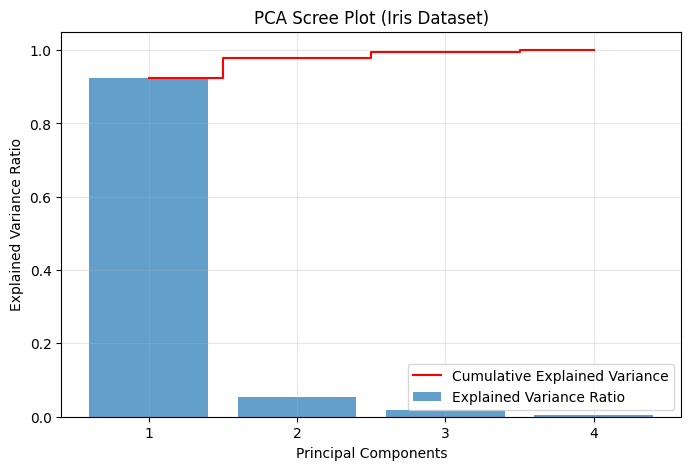

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import numpy as np

# 데이터 로드
X, y = load_iris(return_X_y=True)

# PCA 적용 (전체 주성분 유지)
pca = PCA()
X_pca = pca.fit_transform(X)

# 설명된 분산 비율
explained_var_ratio = pca.explained_variance_ratio_

# 누적 설명 분산
cumulative_var_ratio = np.cumsum(explained_var_ratio)

# -----------------------------
# 📊 Scree Plot 그리기
# -----------------------------
plt.figure(figsize=(8, 5))

# 1) 각 주성분의 분산 비율
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio,
        alpha=0.7, align="center", label="Explained Variance Ratio")

# 2) 누적 분산 비율
# plt.step : 점들을 계단식으로 연결 → 중간값이 유지되다가 갑자기 변화
plt.step(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio,
         where="mid", label="Cumulative Explained Variance", color="red")

plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot (Iris Dataset)")
plt.xticks(range(1, len(explained_var_ratio) + 1))
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

In [9]:
cumulative_var_ratio

array([0.92461872, 0.97768521, 0.99478782, 1.        ])

📌 결과 해석

파란 막대(bar) = 각 주성분(PC1, PC2, …)이 설명하는 분산 비율

빨간 선(step plot) = 누적 분산 비율 (예: PC1+PC2=95%)

보통 누적 분산 비율이 90~95% 이상 되는 지점까지의 주성분만 선택하는 경우가 많음 → 차원 축소 근거

✅ 이 그래프를 보면 Iris 데이터의 경우 보통 2개의 주성분(PC1+PC2) 만으로도 데이터 분산의 대부분(95% 이상)을 설명할 수 있다는 것을 확인할 수 있습니다.

In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 1) 데이터
X, y = load_iris(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2) 파이프라인: 스케일링 → PCA → SVM
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=42)),
    ("svc", SVC(random_state=42, probability=True))
])

# 3) 교차검증 설정 (분류 → StratifiedKFold 권장)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) 파라미터 그리드 (PCA 차원 + SVM 하이퍼파라미터)
param_grid = {
    "pca__n_components": [None, 2, 3],      # Iris는 특성 4개
    "svc__kernel": ["linear", "rbf"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", "auto"],        # rbf에서 유효, linear도 허용됨
}

# 5) GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True
)

# 6) 학습 & 결과
grid.fit(X_tr, y_tr)
print("Best params:", grid.best_params_)
print("CV best score:", grid.best_score_)
print("Test accuracy:", grid.score(X_te, y_te))
print("\nClassification report:\n", classification_report(y_te, grid.predict(X_te)))

Best params: {'pca__n_components': None, 'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
CV best score: 0.975
Test accuracy: 0.9333333333333333

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

